# Obligatorio Series Temporales
### Ventas semanales del agua / temperatura media semanal en Uruguay

# Fuentes de datos

La temperatura se descargó de la web https://en.tutiempo.net/ y los datos son de la estación meteorológica cercana al aeropuerto de Carrasco. La bajada fue por día desde el 01/01/2017 y se pasó a semanal haciendo el promedio de los valores de la semana.

La venta de agua está en litros, también es semanal y del mismo período pero en este caso es la suma de los valores de la semana. Los datos se obtuvieron de una empresa que hace venta minorista, por lo que el factor stock no tiene incidencia en el dataset. Se excluyó aguas saborizadas del análisis y solo se tomó en cuenta agua mineral tanto con como sin gas y en todos sus calibres.

In [1]:
#install.packages("xlsx") 
#install.packages("astsa")

library(xlsx)
library(astsa)
library(lubridate)

options(repr.plot.width=10, repr.plot.height=5) #ajusta tamaño de graficas


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



Adicionalmente a los criterios dados en clase para identificar la mejor predicción de la serie (AIC, BIC, ruido blanco Gaussiano, varianza) utilizaremos la función mape definida a continuación.

In [2]:
mape <- function(actual,pred){
  mape <- mean(abs((actual - pred)/actual))*100
  return (mape)
}

In [3]:
base <- read.xlsx("Base time series.xlsx", sheetIndex = 1)

base_train <- base[base$Class == 'Train',]
base_test <- base[base$Class == 'Test',]

Litros=round(base_train[4] / 10000, 2)
# Normalizamos los datos de venta para pasarlos a la misma escala que la temperatura

Temp = round(base_train[5], 2)
#Temp

In [4]:
head(base)

head(Litros)

head(Temp)

Year Weeknum Yearweek Sales_Liters Temp_Avg Class
1 2017 1       1        263778.2     22.88571 Train
2 2017 2       2        249777.5     23.24286 Train
3 2017 3       3        266308.4     23.52857 Train
4 2017 4       4        261133.6     21.95714 Train
5 2017 5       5        292004.5     24.58571 Train
6 2017 6       6        236130.0     21.11429 Train

Sales_Liters
1 26.38       
2 24.98       
3 26.63       
4 26.11       
5 29.20       
6 23.61

Temp_Avg
1 22.89   
2 23.24   
3 23.53   
4 21.96   
5 24.59   
6 21.11

#  Metodología

Según lo visto en el curso utilizaremos la receta de Box-Jenkins para trabajar con nuestra serie temporal, es decir vamos a:

Graficar los datos

Trasnformar los datos (por ejemplo, transformación logarítmica, o detrend o ambos, diferenciación).

Identificar los órdenes de dependencia (acf, pacf).

Estimación de parámetros (fit, básicamente mínimos cuadrados o máxima verosimilitud).

Diagnóstico (análisis de residuos por ejemplo).

Elección del modelo (criterios de información tipo AIC, evitar overfitting, etc.)

Predicción en base a estimadores lineales calculados recursivamente e intervalos de confianza.

# Graficamos los datos

In [5]:
tsBebidas = ts(Litros,  start=c(2017,1,1), freq = 52) 

In [6]:
tsTemp = ts(Temp,  start=c(2017,1,1), freq = 52)

In [7]:
tsplot(tsBebidas)


In [8]:
tsplot(tsTemp)

In [9]:
tsplot(tsTemp, ylim=c(min(tsTemp),max(tsBebidas)), col = "blue", main = "VENTAS SEMANALES DE AGUA (ROJO) / TEMPERATURA MEDIA (AZUL)")
lines(tsBebidas, col = "red")

###  Prueba de algunos modelos
Se procede a ajustar algunos modelos que representen la serie de Venta de Agua *a partir de la temperatura y de sus valores historicos*:

1. $A_t = \beta_0 + \beta_1 t + w_t.$
2. $A_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + w_t.$
3. $A_t = \beta_0 + \beta_1 t + \beta_2(T_t - \bar{T}) + \beta_3(T_t - \bar{T})^2 + w_t.$


# Modelo 1 : regresión lineal ventas vs trend

In [10]:
A=tsBebidas
T=tsTemp

In [11]:
#   Modelo 1
trend = time(A)        # time

fit = lm(A ~ trend, na.action=NULL)
            
summary(fit)       # regression results

num = length(A)                                         # sample size
AIC(fit)/num - log(2*pi)                                # AIC 
BIC(fit)/num - log(2*pi)                                # BIC


Call:
lm(formula = A ~ trend, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7745 -3.2703 -0.9166  2.3601 11.6573 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -416.3563   774.8193  -0.537    0.592
trend          0.2177     0.3839   0.567    0.571

Residual standard error: 4.152 on 154 degrees of freedom
Multiple R-squared:  0.002084,	Adjusted R-squared:  -0.004396 
F-statistic: 0.3216 on 1 and 154 DF,  p-value: 0.5715


[1] 3.87274

[1] 3.931391

# Modelo 2 : regresión lineal ventas vs trend + centered temp

In [12]:
#  Modelo 2
temp  = T-mean(T)  # center temperature    
trend = time(A)        # time

fit = lm(A ~ trend + temp , na.action=NULL)
            
summary(fit)       # regression results

num = length(A)                                         # sample size
AIC(fit)/num - log(2*pi)                                # AIC 
BIC(fit)/num - log(2*pi)                                # BIC 


Call:
lm(formula = A ~ trend + temp, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1859 -1.7303 -0.3024  1.2555  8.2124 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1955.1057   495.7802  -3.943 0.000122 ***
trend           0.9800     0.2456   3.990 0.000102 ***
temp            0.7466     0.0483  15.458  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.603 on 153 degrees of freedom
Multiple R-squared:  0.6104,	Adjusted R-squared:  0.6054 
F-statistic: 119.9 on 2 and 153 DF,  p-value: < 2.2e-16


[1] 2.944901

[1] 3.023102

# Modelo 3 : regresión lineal ventas vs trend + centered temp + temp^2

In [13]:
#  Modelo 3
Tmed=mean(T)
temp  = T-Tmed  # center temperature    
temp2 = temp^2             # square it  
trend = time(A)        # time

fit = lm(A ~ trend + temp + temp2, na.action=NULL)
            
summary(fit)       # regression results

num = length(A)                                         # sample size
AIC(fit)/num - log(2*pi)                                # AIC 
BIC(fit)/num - log(2*pi)                                # BIC 


Call:
lm(formula = A ~ trend + temp + temp2, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2873 -1.4381 -0.2104  1.2219  8.2644 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.998e+03  4.756e+02  -4.201 4.51e-05 ***
trend        1.001e+00  2.356e-01   4.248 3.74e-05 ***
temp         7.615e-01  4.648e-02  16.381  < 2e-16 ***
temp2        3.790e-02  9.996e-03   3.791 0.000216 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.496 on 152 degrees of freedom
Multiple R-squared:  0.6441,	Adjusted R-squared:  0.6371 
F-statistic: 91.69 on 3 and 152 DF,  p-value: < 2.2e-16


[1] 2.867371

[1] 2.965122

In [14]:
# El modelo 3 es por ahora la mejor aproximacion de acuerdo a los indices de AIC y BIC

predictions = ts(fitted(fit), start = 2017,frequency=52) #Creo una serie temporal con los valores ajustados.
tsplot(A)
lines(predictions,col=2)

# Residuos modelo 3

In [15]:
plot(residuals(fit))

In [16]:
qqnorm(residuals(fit))
qqline(residuals(fit))

# No es Gaussiano

In [17]:
acf(residuals(fit),52)

# No es ruido blanco

Como se puede observar todavia quedan componentes de autocorrelacion

Procederemos con análisis de componentes estacionarias tanto en la serie de Agua como en la de Temperaturas

# Análisis de componentes estacionarias

In [18]:
acf(tsBebidas,181,main="Venta Semanal de Agua")

In [19]:
acf(tsTemp,181,main="Temperatura promedio Semanal")

In [20]:
pairs(cbind(Agua=tsBebidas, Temp=tsTemp))

# Observamos una alta correlación

In [21]:
numA=as.numeric(A)
numT=as.numeric(T)
ccf(numA,numT, 157, main="Venta Semanal Agua vs Temperatura Media", ylab="CCF")

#Vemos una muy fuerte correlación cruzada en el mismo lag, además se notan correlaciones negativas muy altas a los 6 meses y positivas al año, tanto para adelante como para atrás

In [22]:
lag2.plot(numA,numT,3)

La serie de Ventas esta correlacionada fuertemente con la temperatura de la semana actual pero tambien se observa correlacion con las siguientes


In [23]:
lag2.plot(numT,numA,3)

En sentido inverso tambien se observa que el pronostico de temperatura para una semana dos y hasta tres tienen gran correlacion con la venta actual de Agua


### Observaciones:

* La serie de Venta de Bebidas al igual que la Temperatura muestra correlaciones fuertes cada  6 y cada 12 meses.
* Cada 6 meses se obtiene el pico de correlacion negativa debido a estar en la estación opuesta.
* Cada 12 meses se da el pico de correlacion positivo porque tiene una fuerte estacionalidad anual.
* Se observa cierta correlacion en las ventas de acuerdo a las temperaturas experimentadas en las semanas anteriores y tambien pronosticos.


Se propone un modelo:

$$A_t = \beta_0 + \beta_1 T_{t} + \beta_2 T_{t−1} +\beta_3 T_{t+1}   + w_t.$$

Es decir, estimar la venta de agua actual por una media más algo que depende de la temperatura actual, la previa y el pronostico de la semana siguiente.

*Problema:* como alineamos las series $A$ y $T_{t}$, $T_{t-1}$ ,$T_{t+1}$.

In [24]:
temp_ant=lag(tsTemp,-1)
temp_post=lag(tsTemp,1)

In [25]:

agua = ts.intersect(A,tsTemp,temp_ant,temp_post, dframe=TRUE)
agua

Sales_Liters Temp_Avg Temp_Avg.1 Temp_Avg.2
1   24.98        23.24    22.89      23.53     
2   26.63        23.53    23.24      21.96     
3   26.11        21.96    23.53      24.59     
4   29.20        24.59    21.96      21.11     
5   23.61        21.11    24.59      23.70     
6   24.68        23.70    21.11      25.69     
7   32.57        25.69    23.70      25.31     
8   33.54        25.31    25.69      20.57     
9   26.14        20.57    25.31      17.86     
10  22.71        17.86    20.57      20.00     
11  23.50        20.00    17.86      21.86     
12  24.23        21.86    20.00      21.00     
13  23.85        21.00    21.86      17.71     
14  21.20        17.71    21.00      17.14     
15  19.81        17.14    17.71      16.86     
16  19.91        16.86    17.14      18.86     
17  20.55        18.86    16.86      15.86     
18  19.36        15.86    18.86      14.29     
19  17.93        14.29    15.86      14.57     
20  18.38        14.57    14.29      11.43     
21  18.59        11.43    14.57      10.43     
22  18.20        10.43    11.43      14.14     
23  18.60        14.14    10.43      13.14     
24  18.26        13.14    14.14      14.57     
25  19.56        14.57    13.14      13.57     
26  19.08        13.57    14.57      14.71     
27  18.36        14.71    13.57       8.43     
28  18.32         8.43    14.71      15.86     
29  20.02        15.86     8.43      11.29     
30  19.99        11.29    15.86      14.71     
... ...          ...      ...        ...       
125 20.79        16.21    16.00      13.79     
126 21.52        13.79    16.21      12.86     
127 20.20        12.86    13.79      12.93     
128 20.60        12.93    12.86      15.64     
129 19.18        15.64    12.93      14.71     
130 19.29        14.71    15.64      12.86     
131 19.08        12.86    14.71       7.86     
132 19.64         7.86    12.86      10.64     
133 19.85        10.64     7.86      11.21     
134 20.36        11.21    10.64      12.21     
135 20.69        12.21    11.21      10.21     
136 19.92        10.21    12.21      11.29     
137 19.67        11.29    10.21      10.36     
138 22.37        10.36    11.29       8.14     
139 21.75         8.14    10.36      14.50     
140 20.37        14.50     8.14       9.29     
141 21.93         9.29    14.50      11.29     
142 23.76        11.29     9.29      12.86     
143 24.17        12.86    11.29      14.14     
144 25.37        14.14    12.86      14.29     
145 21.68        14.29    14.14      17.07     
146 22.96        17.07    14.29      13.57     
147 24.29        13.57    17.07      15.14     
148 26.06        15.14    13.57      18.53     
149 27.40        18.53    15.14      17.96     
150 31.59        17.96    18.53      19.67     
151 26.08        19.67    17.96      22.61     
152 26.45        22.61    19.67      20.33     
153 32.46        20.33    22.61      17.61     
154 27.39        17.61    20.33      22.96

# Modelo 4: Regresión ventas t vs temperatura t + temperatura t+1 + temperatura t-1

In [26]:
summary(fit1 <- lm(A ~ tsTemp + +temp_ant + temp_post , data=agua, na.action=NULL))


Call:
lm(formula = A ~ tsTemp + +temp_ant + temp_post, data = agua, 
    na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1714 -1.9582 -0.4968  1.2242  8.9426 

Coefficients: (2 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.97180    0.87288   12.57   <2e-16 ***
tsTemp       0.70791    0.04956   14.29   <2e-16 ***
temp_ant          NA         NA      NA       NA    
temp_post         NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.726 on 154 degrees of freedom
Multiple R-squared:  0.5699,	Adjusted R-squared:  0.5671 
F-statistic: 204.1 on 1 and 154 DF,  p-value: < 2.2e-16


In [27]:
plot(temp_post,temp_ant)
cor(temp_post,temp_ant)

Temp_Avg
Temp_Avg 1

Los Coeficientes correspondientes a la temperatura actual se obtienen, pero para la anterior y para el pronostico futuro no ya que existe una fuerte correlacion entre ambos ; *Nota error: Error "not defined because of singularities" will occur due to strong correlation between your independent variables*

En conclusión: obligatoriamente tenemos que sacar la periodicidad de la serie

### Componentes Estacionales y Periodograma de las ventas


In [28]:
plot(acf(T,lag.max=100))

In [29]:
# Periodograma

n=length(A)
I = abs(fft(A))^2/n # the periodogram
P = (4/n)*I[1:(n/2)]
# the scaled periodogram
f = (0:(n/2-1))/n
# frequencies
plot(f, P, type="l", xlab="Frequency", ylab="Scaled Periodogram")


El pico se debe a la componente de continua que tiene la serie, es decir que la transformada de fourier grafica todas las componentes , y la continua es una delta (salto infinito) en el origen

In [30]:
# Para sacar la componente de continua se resta la media nada mas
Amed=mean(A)
A=A-Amed

In [31]:
# Periodograma
n=length(A)
I = abs(fft(A))^2/n # the periodogram
P = (4/n)*I[1:(n/2)]
# the scaled periodogram
f = (0:(n/2-1))/n
# frequencies
plot(f, P, type="l", xlab="Frequency", ylab="Scaled Periodogram",xlim=c(0,0.5),ylim=c(0,200))

## Ahi  si graficando en todo el rango se visualiza mejor 

In [32]:
# Periodograma
n=length(A)
I = abs(fft(A))^2/n # the periodogram
P = (4/n)*I[1:(n/2)]
# the scaled periodogram
f = (0:(n/2-1))/n
# frequencies
plot(f, P, type="l", xlab="Frequency", ylab="Scaled Periodogram",xlim=c(0,0.08),ylim=c(0,25))

## Ahi  si graficando en todo el rango se visualiza mejor 

In [33]:
which.max(P)
# hay otra compnente en frecuencia 0.04 (periodo de 25 semanas)  y posiblemente en 0.05 (periodo  20 semanas) ,mas chiquitas y otra en  0.7, 14 semanas 

[1] 4

In [34]:
f

[1] 0.000000000 0.006410256 0.012820513 0.019230769 0.025641026 0.032051282
 [7] 0.038461538 0.044871795 0.051282051 0.057692308 0.064102564 0.070512821
[13] 0.076923077 0.083333333 0.089743590 0.096153846 0.102564103 0.108974359
[19] 0.115384615 0.121794872 0.128205128 0.134615385 0.141025641 0.147435897
[25] 0.153846154 0.160256410 0.166666667 0.173076923 0.179487179 0.185897436
[31] 0.192307692 0.198717949 0.205128205 0.211538462 0.217948718 0.224358974
[37] 0.230769231 0.237179487 0.243589744 0.250000000 0.256410256 0.262820513
[43] 0.269230769 0.275641026 0.282051282 0.288461538 0.294871795 0.301282051
[49] 0.307692308 0.314102564 0.320512821 0.326923077 0.333333333 0.339743590
[55] 0.346153846 0.352564103 0.358974359 0.365384615 0.371794872 0.378205128
[61] 0.384615385 0.391025641 0.397435897 0.403846154 0.410256410 0.416666667
[67] 0.423076923 0.429487179 0.435897436 0.442307692 0.448717949 0.455128205
[73] 0.461538462 0.467948718 0.474358974 0.480769231 0.487179487 0.493589744

In [35]:
Tmed
mean(T)
T=T-Tmed

[1] 17.05474

[1] 17.05474

# Periodograma de la temperatura

In [36]:
n=length(T)
I = abs(fft(T))^2/n # the periodogram
P = (4/n)*I[1:(n/2)]
# the scaled periodogram
f = (0:(n/2-1))/n
# frequencies
plot(f, P, type="l", xlab="Frequency", ylab="Scaled Periodogram",xlim=c(0,0.5),ylim=c(0,35))

In [37]:
plot(f, P, type="l", xlab="Frequency", ylab="Scaled Periodogram",xlim=c(0,0.08),ylim=c(0,35))

In [38]:
max(P)

[1] 31.33441

In [39]:
(which.max(P))

[1] 4

In [40]:
f1=f[4]
f2=f[8]
f3=f[9]
f4=f[12]


In [41]:
f1
1/f1
f2
1/f2
f3
1/f3
f4
1/f4

[1] 0.01923077

[1] 52

[1] 0.04487179

[1] 22.28571

[1] 0.05128205

[1] 19.5

[1] 0.07051282

[1] 14.18182

La componente f1 ( 1/0.19 ~ 52 semanas) y f3 ( 1/0.050 ~ 20 semanas) se encuentras en ambas series

In [42]:
periodo_ppal= 1/f1
periodo_ppal
periodo_secundario = 1/f3
periodo_secundario

[1] 52

[1] 19.5

In [43]:
# Normalizamos la ts Ventas

trend=time(A)
amp_max = max(c( max(A), max(-A)))
A_norm=A/amp_max

# Modelo 5 : ajuste de las ventas normalizadas vs sin + cos

In [44]:
fit_estacional = lm(A_norm ~ sin(2*pi*trend*f1*52) + cos(2*pi*trend*f1*52) ,na.action=NULL)

In [45]:
summary(fit_estacional)


Call:
lm(formula = A_norm ~ sin(2 * pi * trend * f1 * 52) + cos(2 * 
    pi * trend * f1 * 52), na.action = NULL)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39164 -0.12326 -0.01602  0.09543  0.59454 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -2.883e-14  1.484e-02   0.000        1    
sin(2 * pi * trend * f1 * 52)  8.453e-02  2.099e-02   4.027 8.87e-05 ***
cos(2 * pi * trend * f1 * 52)  4.135e-01  2.099e-02  19.702  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1854 on 153 degrees of freedom
Multiple R-squared:  0.7255,	Adjusted R-squared:  0.7219 
F-statistic: 202.2 on 2 and 153 DF,  p-value: < 2.2e-16


In [46]:
num = length(A)                                         # sample size
AIC(fit_estacional)/num - log(2*pi)                                # AIC 
BIC(fit_estacional)/num - log(2*pi)                                # BIC

[1] -2.338804

[1] -2.260603

In [47]:
#transformo el resultado en una serie
predictions = ts(fitted(fit_estacional),start=2017, frequency=52)

plot(A_norm )
lines(predictions,col=2)



In [48]:
residuos=residuals(fit_estacional)

In [49]:
plot(residuos, ylim=c(-0.5,1) )
lines(A_norm,col=2)

In [50]:
acf(residuos)

Mejora el modelo pero existen todavia algunas componentes de correlacion , vamos a probar ajustar un modelo con mas componentes estacionarias

# Modelo 6 : modelo no lineal con tres componentes estacionarias

In [51]:
## haciendo un planteo de modelo no linea7
fit2_estacional <- nls( A_norm ~ a *(sin(2*pi*trend*f_1*52) + cos(2*pi*trend*f_1*52)) +b*(sin(2*pi*trend*f_2*52) + cos(2*pi*trend*f_2*52)) + c*(sin(2*pi*trend*f_3*52) + cos(2*pi*trend*f_3*52)),start=list(a=0.5,b=0.4,c=0.7,f_1=f1,f_2=f3,f_3=f4))


In [52]:
summary(fit2_estacional)


Formula: A_norm ~ a * (sin(2 * pi * trend * f_1 * 52) + cos(2 * pi * trend * 
    f_1 * 52)) + b * (sin(2 * pi * trend * f_2 * 52) + cos(2 * 
    pi * trend * f_2 * 52)) + c * (sin(2 * pi * trend * f_3 * 
    52) + cos(2 * pi * trend * f_3 * 52))

Parameters:
     Estimate Std. Error   t value Pr(>|t|)    
a   2.985e-01  1.395e-02 2.139e+01  < 2e-16 ***
b   4.916e-02  1.395e-02 3.524e+00 0.000563 ***
c   4.582e-02  1.395e-02 3.285e+00 0.001270 ** 
f_1 1.923e-02  7.087e-08 2.714e+05  < 2e-16 ***
f_2 5.128e-02  4.302e-07 1.192e+05  < 2e-16 ***
f_3 7.050e-02  4.617e-07 1.527e+05  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1742 on 150 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 2.887e-07


In [53]:
coef(fit2_estacional)

# f_1, f_2 y f_3 dan muy cercano a lo que nos había dado el periodograma

a          b          c        f_1        f_2        f_3 
0.29845374 0.04916313 0.04582023 0.01923165 0.05128092 0.07050133

In [54]:
#transformo el resultado en una serie
predictions2 = ts(fitted(fit2_estacional),start=2017, frequency=52)

plot(A_norm )
lines(predictions2,col=2)

# Estudiamos los residuos del modelo 6

In [55]:
round(mape(A_norm, predictions2))

[1] 141

In [56]:
residuos2=residuals(fit2_estacional)
tsplot(trend,residuos2)
lines(predictions2+residuos2,col=5,ylim=c(-10,10))
lines(predictions2,col=8,ylim=c(-10,10))

# Los residuos más altos se deben a que no captamos los picos altos de venta

In [57]:
plot(trend,residuos2)
lines(A_norm,col=2)

In [58]:
acf(residuos2,52)

# No es ruido blanco

# Componentes Estacionales de la temperatura

In [59]:
trend=time(T)
temp_max = max(c( max(T), max(-T)))
T_norm=T/temp_max

In [60]:
fit_temp_estacional = lm(T_norm ~ sin(2*pi*trend*f1*52) + cos(2*pi*trend*f1*52) ,na.action=NULL)

In [61]:
summary(fit_temp_estacional)


Call:
lm(formula = T_norm ~ sin(2 * pi * trend * f1 * 52) + cos(2 * 
    pi * trend * f1 * 52), na.action = NULL)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53721 -0.14075 -0.01347  0.15190  0.50941 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -5.085e-14  1.697e-02    0.00        1    
sin(2 * pi * trend * f1 * 52)  3.063e-01  2.400e-02   12.76   <2e-16 ***
cos(2 * pi * trend * f1 * 52)  5.261e-01  2.400e-02   21.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.212 on 153 degrees of freedom
Multiple R-squared:  0.8078,	Adjusted R-squared:  0.8053 
F-statistic: 321.6 on 2 and 153 DF,  p-value: < 2.2e-16


In [62]:
num = length(T)                                         # sample size
AIC(fit_temp_estacional)/num - log(2*pi)                                # AIC 
BIC(fit_temp_estacional)/num - log(2*pi)                                # BIC

[1] -2.070414

[1] -1.992213

In [63]:
#transformo el resultado en una serie
predictions = ts(fitted(fit_temp_estacional),start=2017, frequency=52)

plot(T )
lines(predictions*temp_max,col=2)

In [64]:
round(mape(T_norm, predictions))

[1] 140

In [65]:
residuos_temp=residuals(fit_temp_estacional)

In [66]:
plot(residuos_temp,ylim=c(-1,1))
lines(predictions +residuos_temp,col=4) # la serie original (predicción ´+ residuos)

In [67]:
acf(residuos_temp, 52)

El residuo queda practicamente blanco por lo tanto podemos considerar que conseguimos extraer toda la componente estacionaria con frecuencia f1, periodo  52 Semanas

# Buscamos mejorar nuestro Modelo 6 extrayendo las componentes estacionarias para explicar el comportamiento de la serie sin las tres componentes del modelo

In [68]:
residuos_venta=ts(residuos2,start=c(2017,1,1),freq=52)

In [69]:
num_resA=as.numeric(residuos_venta)
num_resT=as.numeric(residuos_temp)
lag2.plot(num_resA,num_resT,3)

In [70]:
lag2.plot(num_resT,num_resA,3)

In [71]:
ccf(num_resA,num_resT, 157, main="Venta Semanal Agua vs Temperatura Media", ylab="CCF")

# En los residuos vemos muy poca correlación

### Modelo 7 : Función de Ventas vs temperatura t + residuos(temperatura t-1) + temperatura t+1



$$resA_t = \beta_0 + \beta_1 (resT_{t}) + \beta_2 (resT_{t−1}) +\beta_3 (resT_{t+1})   + w_t.$$

Es decir, estimar la venta de agua actual por una media más algo que depende de la temperatura actual, el residuo en el cambio de la semana previa y el pronostico de la semana siguiente.



In [72]:

restemp_ant=lag(residuos_temp,-1)  # past temp
restemp_post=lag(residuos_temp,1)  # forecast tem

trend = time(residuos_temp)        # time

residuos_temp2  = residuos_temp^2  # square it 
restemp_ant2 = restemp_ant^2 
restemp_post2 = restemp_post^2

# Aplicamos la función sign para tener valores positivos y negativos según si crece o decrere la temperatura

residuos_temp_exp  = sign(residuos_temp)*exp(residuos_temp)  # exponential it 
restemp_ant_exp = sign(restemp_ant)*exp(restemp_ant )
restemp_post_exp = sign(restemp_post)*exp(restemp_post)


In [73]:

res_agua = ts.intersect(trend,residuos_venta,residuos_temp, residuos_temp2, residuos_temp_exp,  restemp_ant,restemp_ant2,restemp_post,restemp_post2,restemp_ant_exp,restemp_post_exp, dframe=TRUE)
res_agua

trend    residuos_venta residuos_temp residuos_temp2 residuos_temp_exp
2   2017.019 -0.133886957    0.11346833   0.0128750619    1.1201564       
3   2017.038  0.015265424    0.12008213   0.0144197188    1.1275895       
4   2017.058 -0.033013742   -0.06707530   0.0044990953   -0.9351248       
5   2017.077  0.212810317    0.21130752   0.0446508662    1.2352922       
6   2017.096 -0.286161760   -0.16595070   0.0275396344   -0.8470880       
7   2017.115 -0.222120870    0.12580218   0.0158261883    1.1340578       
8   2017.135  0.425804115    0.36100484   0.1303244931    1.4347704       
9   2017.154  0.498890182    0.34688221   0.1203272688    1.4146501       
10  2017.173 -0.120112919   -0.13339042   0.0177930038   -0.8751234       
11  2017.192 -0.380711640   -0.38536464   0.1485059046   -0.6802026       
12  2017.212 -0.261273537   -0.10296701   0.0106022042   -0.9021567       
13  2017.231 -0.127611140    0.15515092   0.0240718074    1.1678342       
14  2017.250 -0.074074320    0.12280602   0.0150813180    1.1306651       
15  2017.269 -0.206086220   -0.16935419   0.0286808411   -0.8442098       
16  2017.288 -0.231704479   -0.16218444   0.0263037942   -0.8502844       
17  2017.308 -0.138404346   -0.12097472   0.0146348821   -0.8860564       
18  2017.327 -0.012150767    0.16965801   0.0287838397    1.1848996       
19  2017.346 -0.057064281   -0.08310920   0.0069071392   -0.9202506       
20  2017.365 -0.138660899   -0.18103563   0.0327739004   -0.8344056       
21  2017.385 -0.075128616   -0.07950494   0.0063210362   -0.9235735       
22  2017.404 -0.042718704   -0.35270718   0.1244023532   -0.7027830       
23  2017.423 -0.067533800   -0.39694494   0.1575652876   -0.6723710       
24  2017.442 -0.027369437    0.06634844   0.0044021149    1.0685990       
25  2017.462 -0.048859963    0.01180252   0.0001392995    1.0118724       
26  2017.481  0.071473500    0.21515740   0.0462927089    1.2400571       
27  2017.500  0.043084146    0.14715274   0.0216539293    1.1585309       
28  2017.519 -0.005371428    0.30421736   0.0925482022    1.3555637       
29  2017.538  0.001043961   -0.35385561   0.1252137931   -0.7019763       
30  2017.558  0.148824836    0.47062247   0.2214855121    1.6009905       
31  2017.577  0.140599457   -0.01875045   0.0003515795   -0.9814242       
... ...      ...            ...           ...            ...              
126 2019.404  0.028146434    0.16715506   0.0279408149    1.1819375       
127 2019.423  0.133388620   -0.03151877   0.0009934326   -0.9689728       
128 2019.442  0.067627578   -0.07286154   0.0053088036   -0.9297296       
129 2019.462  0.146069067   -0.01103662   0.0001218069   -0.9890241       
130 2019.481  0.063639526    0.33152824   0.1099109747    1.3930955       
131 2019.500  0.100799654    0.27113662   0.0735150683    1.3114542       
132 2019.519  0.098332119    0.10301545   0.0106121823    1.1085085       
133 2019.538  0.148367550   -0.41584755   0.1729291859   -0.6597808       
134 2019.558  0.157302675   -0.09709320   0.0094270885   -0.9074714       
135 2019.577  0.183059809   -0.02745108   0.0007535616   -0.9729223       
136 2019.596  0.188287946    0.08008782   0.0064140585    1.0833822       
137 2019.615  0.098083216   -0.14749796   0.0217556494   -0.8628642       
138 2019.635  0.052099668   -0.04881421   0.0023828266   -0.9523581       
139 2019.654  0.257238969   -0.17716428   0.0313871838   -0.8376422       
140 2019.673  0.180532063   -0.45384588   0.2059760813   -0.6351806       
141 2019.692  0.036855974    0.19509428   0.0380617772    1.2154256       
142 2019.712  0.136992506   -0.42118977   0.1774008251   -0.6562655       
143 2019.731  0.251193676   -0.25950262   0.0673416119   -0.7714352       
144 2019.750  0.233736197   -0.14993969   0.0224819113   -0.8607599       
145 2019.769  0.271451616   -0.07638265   0.0058343085   -0.9264616       
146 2019.788 -0.116230400   -0.12923066   0.0167005638   -0.8787712       
147 2019.808 -0.089097273    

In [74]:
num = length(res_agua)                                         # sample size
    
summary(fit_res <- lm(residuos_venta ~  residuos_temp + residuos_temp2 +  residuos_temp_exp +  restemp_ant  + restemp_ant2 +restemp_ant_exp + restemp_post + restemp_post2 + restemp_post_exp   , data=res_agua, na.action=NULL))

AIC(fit_res)/num - log(2*pi)                                # AIC 
BIC(fit_res)/num - log(2*pi)                                # BIC


Call:
lm(formula = residuos_venta ~ residuos_temp + residuos_temp2 + 
    residuos_temp_exp + restemp_ant + restemp_ant2 + restemp_ant_exp + 
    restemp_post + restemp_post2 + restemp_post_exp, data = res_agua, 
    na.action = NULL)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50487 -0.10989 -0.01250  0.09026  0.45414 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)       -0.0015059  0.0221173  -0.068   0.9458   
residuos_temp      0.3081217  0.1161844   2.652   0.0089 **
residuos_temp2     0.1493599  0.2562121   0.583   0.5608   
residuos_temp_exp -0.0615818  0.0236611  -2.603   0.0102 * 
restemp_ant        0.1819881  0.1169788   1.556   0.1220   
restemp_ant2       0.0937169  0.2559178   0.366   0.7148   
restemp_ant_exp   -0.0515322  0.0235756  -2.186   0.0304 * 
restemp_post      -0.0235971  0.1161218  -0.203   0.8393   
restemp_post2      0.0467675  0.2578199   0.181   0.8563   
restemp_post_exp  -0.0006471  0.0237585  -0.0

[1] -10.70264

[1] -7.665689

In [75]:
fit_nls <- nls(residuos_venta ~ g*residuos_temp + h*residuos_temp2 + i*restemp_ant + j*restemp_post+ k*restemp_post_exp, start=list(g=0.5,h=0.5,i=1.1,j=0.9,k=0.1), data=res_agua, na.action=NULL)

In [76]:
summary(fit_nls)
AIC(fit_res)/num - log(2*pi)                                # AIC 
BIC(fit_res)/num - log(2*pi)                                # BIC


Formula: residuos_venta ~ g * residuos_temp + h * residuos_temp2 + i * 
    restemp_ant + j * restemp_post + k * restemp_post_exp

Parameters:
    Estimate Std. Error t value Pr(>|t|)
g  0.0605975  0.0682539   0.888    0.376
h -0.0551075  0.1942592  -0.284    0.777
i -0.0210050  0.0687997  -0.305    0.761
j -0.0201838  0.1124583  -0.179    0.858
k -0.0003184  0.0227548  -0.014    0.989

Residual standard error: 0.1738 on 149 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 1.034e-08


[1] -10.70264

[1] -7.665689

# Análisis de residuos Modelo 7

In [77]:
plot(residuals(fit_res))

In [78]:
# hasta aqui se obtiene la mejor aproximacion de acuerdo a los indices de AIC y BIC
predict_nls = ts(fitted(fit_nls), start = 2017,frequency=52) #Creo una serie temporal con los valores ajustados.
tsplot(residuos_venta,ylim=c(-2,2))


In [79]:
qqnorm(residuals(fit_res))
qqline(residuals(fit_res))

In [80]:
acf(residuals(fit_res),52)

# Hacemos predicción combinando lo aprendido en el Modelo 6 y el Modelo 7 y comparamos con los datos de test, los cuáles nuestro modelo no ha visto cuando se entrenó

In [81]:
head(base_test)

Year Weeknum Yearweek Sales_Liters Temp_Avg Class
157 2020 157     1        297444.3     21.44286 Test 
158 2020 158     2        297221.2     21.98571 Test 
159 2020 159     3        285992.0     23.73333 Test 
160 2020 160     4        322162.2     21.37500 Test 
161 2020 161     5        287530.2     23.61429 Test 
162 2020 162     6        372673.3     21.38571 Test

In [82]:
Litros_test=base_test[4] / 10000
# Normalizamos los datos de venta para pasarlos a la misma escala que la temperatura

Temp_test = round(base_test[5],2)
#Temp

In [83]:
tsBebidas_test = ts(Litros_test,  start=c(2020,1,1), freq = 52) 

tsTemp_test = ts(Temp_test,  start=c(2020,1,1), freq = 52)

In [84]:
trend_test=time(tsBebidas_test)

In [85]:
options(repr.plot.width=14, repr.plot.height=8) #ajusta tamaño de graficas

In [86]:
tsplot(tsBebidas_test,ylim=c(0,45))
lines(tsTemp_test,col=2)

# Ventas vs temp

# Reconstruyendo el Modelo 7 y agregamos las componentes estacionales del Modelo 6

In [87]:
# Componentes estacionales de las ventas

coef(fit2_estacional)

a          b          c        f_1        f_2        f_3 
0.29845374 0.04916313 0.04582023 0.01923165 0.05128092 0.07050133

In [88]:
# Modelo 7 (nls de los residuos)

coef(fit_nls)

g            h            i            j            k 
 0.060597497 -0.055107474 -0.021004953 -0.020183803 -0.000318394

In [89]:
coefs_estacional=as.numeric(coef(fit2_estacional))
a=coefs_estacional[1]
b=coefs_estacional[2]
c=coefs_estacional[3]
f1=coefs_estacional[4]
f2=coefs_estacional[5]
f3=coefs_estacional[6]

In [90]:
coefs_nls=as.numeric(coef(fit_nls))
g=coefs_nls[1]
h=coefs_nls[2]
i=coefs_nls[3]
j=coefs_nls[4]
k=coefs_nls[5]
print(trend_test)

Time Series:
Start = c(2020, 1) 
End = c(2020, 25) 
Frequency = 52 
 [1] 2020.000 2020.019 2020.038 2020.058 2020.077 2020.096 2020.115 2020.135
 [9] 2020.154 2020.173 2020.192 2020.212 2020.231 2020.250 2020.269 2020.288
[17] 2020.308 2020.327 2020.346 2020.365 2020.385 2020.404 2020.423 2020.442
[25] 2020.462


In [91]:
T_estacional_test = (sin(2*pi*trend_test*f1*52) + cos(2*pi*trend_test*f1*52))
tsplot(T_estacional_test)


In [92]:
residuos_temp_test=as.numeric((tsTemp_test-Tmed)/temp_max) - (T_estacional_test)

In [93]:

restemp_ant_test=lag(residuos_temp_test,-1)  # past temp
restemp_post_test=lag(residuos_temp_test,1)  # forecast tem

#trend_test= time(residuos_temp_test)        # time

residuos_temp_test2  = residuos_temp_test^2  # square it 
restemp_ant_test2 = restemp_ant_test^2 
restemp_post_test2 = restemp_post_test^2

residuos_temp_test_exp  = sign(residuos_temp_test)*exp(residuos_temp_test)  # exponential it 
restemp_ant_test_exp = sign(restemp_ant_test)*exp(restemp_ant_test )
restemp_post_test_exp = sign(restemp_post_test)*exp(restemp_post_test)


In [94]:

res_agua_test = ts.intersect(trend_test,residuos_temp_test, residuos_temp_test2, residuos_temp_test_exp,  restemp_ant_test,restemp_ant_test2,restemp_post_test,restemp_post_test2,restemp_ant_test_exp,restemp_post_test_exp, dframe=TRUE)
res_agua_test

trend_test residuos_temp_test residuos_temp_test2 residuos_temp_test_exp
1  2020.019   -0.8729057         0.761964385         -0.4177360            
2  2020.038   -0.6870673         0.472061492         -0.5030492            
3  2020.058   -0.9254409         0.856440822         -0.3963566            
4  2020.077   -0.6453473         0.416473154         -0.5244804            
5  2020.096   -0.8294173         0.687933018         -0.4363035            
6  2020.115   -0.4213617         0.177545713         -0.6561527            
7  2020.135   -0.7165118         0.513389132         -0.4884531            
8  2020.154   -0.0435464         0.001896289         -0.9573881            
9  2020.173   -0.3856468         0.148723430         -0.6800107            
10 2020.192   -0.2285604         0.052239841         -0.7956783            
11 2020.212   -0.2464316         0.060728532         -0.7815848            
12 2020.231    0.1784770         0.031854045          1.1953954            
13 2020.250    0.3053893         0.093262608          1.3571532            
14 2020.269    0.1743147         0.030385630          1.1904302            
15 2020.288    0.6996156         0.489461945          2.0129787            
16 2020.308    0.5704454         0.325407917          1.7690548            
17 2020.327    0.3944574         0.155596635          1.4835790            
18 2020.346    0.5389985         0.290519408          1.7142892            
19 2020.365    0.9071036         0.822837009          2.4771374            
20 2020.385    0.8320348         0.692281869          2.2979899            
21 2020.404    0.5901345         0.348258728          1.8042311            
22 2020.423    0.7700610         0.592993937          2.1598980            
23 2020.442    1.2211279         1.491153354          3.3910103            
   restemp_ant_test restemp_ant_test2 restemp_post_test restemp_post_test2
1  -0.9087645       0.825852978       -0.6870673        0.472061492       
2  -0.8729057       0.761964385       -0.9254409        0.856440822       
3  -0.6870673       0.472061492       -0.6453473        0.416473154       
4  -0.9254409       0.856440822       -0.8294173        0.687933018       
5  -0.6453473       0.416473154       -0.4213617        0.177545713       
6  -0.8294173       0.687933018       -0.7165118        0.513389132       
7  -0.4213617       0.177545713       -0.0435464        0.001896289       
8  -0.7165118       0.513389132       -0.3856468        0.148723430       
9  -0.0435464       0.001896289       -0.2285604        0.052239841       
10 -0.3856468       0.148723430       -0.2464316        0.060728532       
11 -0.2285604       0.052239841        0.1784770        0.031854045       
12 -0.2464316       0.060728532        0.3053893        0.093262608       
13  0.1784770       0.031854045        0.1743147        0.030385630       
14  0.3053893       0.093262608        0.6996156        0.489461945       
15  0.1743147       0.030385630        0.5704454        0.325407917       
16  0.6996156       0.489461945        0.3944574        0.155596635       
17  0.5704454       0.325407917        0.5389985        0.290519408       
18  0.3944574       0.155596635        0.9071036        0.822837009       
19  0.5389985       0.290519408        0.8320348        0.692281869       
20  0.9071036       0.822837009        0.5901345        0.348258728       
21  0.8320348       0.692281869        0.7700610        0.592993937       
22  0.5901345       0.348258728        1.2211279        1.491153354       
23  0.7700610       0.592993937        0.8597401        0.739152974       
   restemp_ant_test_exp restemp_post_test_exp
1  -0.4030218           -0.5030492           
2  -0.4177360           -0.3963566           
3  -0.5030492           -0.5244804           
4  -0.3963566           -0.4363035           
5  -0.5244804           -0.6561527           
6  -0.4363035           -0.4884531           
7  -0.6561527           -0.9573881           
8  -0.48845

In [95]:

 A_test = a *(sin(2*pi*trend_test*f1*52) + cos(2*pi*trend_test*f1*52)) +b*(sin(2*pi*trend_test*f2*52) + cos(2*pi*trend_test*f2*52)) + c*(sin(2*pi*trend_test*f3*52) + cos(2*pi*trend_test*f3*52))


In [96]:
residuos_venta_test = g*residuos_temp_test + h*residuos_temp_test2 + i*restemp_ant_test + j*restemp_post_test+ k*restemp_post_test_exp

In [97]:
plot((A_test + residuos_venta_test)*amp_max+Amed,ylim=c(0,50))
lines(tsBebidas_test,col=2)
pred_test=(A_test + residuos_venta_test)*amp_max+Amed

# Predicción vs datos reales

La predicción da muy bien. No toma los picos de ventas que se deben a compras de pánico por el Covid 19.
En nuestro dataset no habíamos tenido un comportamiento similar por lo que nos parece razonable y esperable que el modelo no captara estos picos.

In [98]:
length(pred_test)
length(tsBebidas_test)


[1] 23

[1] 25

In [99]:
pred_agua_test = ts.intersect(pred_test,tsBebidas_test, dframe=TRUE)
print(pred_agua_test$pred_test)
print(pred_agua_test$Sum.Litros)

Time Series:
Start = c(2020, 2) 
End = c(2020, 24) 
Frequency = 52 
 [1] 25.83519 26.09151 25.60390 26.38106 26.19529 27.24741 26.81400 27.89104
 [9] 27.24611 27.15471 26.37487 25.82787 24.79523 23.48804 22.53880 21.46317
[17] 20.59290 19.89757 19.32672 19.02654 18.88048 18.70279 18.41705
NULL


In [100]:
head(pred_agua_test)

pred_test Sales_Liters
1 25.83519  29.72212    
2 26.09151  28.59920    
3 25.60390  32.21622    
4 26.38106  28.75303    
5 26.19529  37.26733    
6 27.24741  28.42089

In [101]:
round(mape(pred_agua_test$pred_test,pred_agua_test$Sales_Liters),2)

[1] 10.68

Fue posible predecir la venta de de agua para el perido de 2020 con una exactitud del 89,3%

# Modelo 8 : ARMAX - Multivariable AR

Finalmente realizaremos un analisis utilizando una libreria que permite aplicar modelos Autoregresivos (AR) y de media móvil (MA) para procesos que utilizan varias variables o sea ARIMA multivariable.

Este análisis se realizó basandose en el Capítulo 5.6 de Libro del Curso


In [102]:
install.packages("vars")

Installing package into ‘/home/nbuser/R’
(as ‘lib’ is unspecified)


In [103]:
library(vars)

Loading required package: MASS
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest


In [104]:

tsBebidas2=tsBebidas^2
tsTemp2=tsTemp^2
x = cbind(tsBebidas, tsTemp,tsTemp2)
summary(VAR(x, p=1, type='both'))  # Primer aporxmacion para un corrimiento 
#lag=1,orden de p=1 incluyendo const + trend


VAR Estimation Results:
Endogenous variables: tsBebidas, tsTemp, tsTemp2 
Deterministic variables: both 
Sample size: 155 
Log Likelihood: -1347.9 
Roots of the characteristic polynomial:
0.8876 0.4186 0.2243
Call:
VAR(y = x, p = 1, type = "both")


Estimation results for equation tsBebidas: 
tsBebidas = tsBebidas.l1 + tsTemp.l1 + tsTemp2.l1 + const + trend 

              Estimate Std. Error t value Pr(>|t|)    
tsBebidas.l1  0.639741   0.074095   8.634 8.05e-15 ***
tsTemp.l1    -0.177046   0.310845  -0.570   0.5698    
tsTemp2.l1    0.011818   0.009517   1.242   0.2163    
const         7.046036   2.896846   2.432   0.0162 *  
trend         0.007677   0.004425   1.735   0.0848 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 2.256 on 150 degrees of freedom
Multiple R-Squared: 0.7118,	Adjusted R-squared: 0.7041 
F-statistic: 92.63 on 4 and 150 DF,  p-value: < 2.2e-16 


Estimation results for equation tsTemp: 
tsTemp = tsBebidas.l1 + t

* Obtuvimos una aproximacion: 



$A_t = 7.046036 -  0.007677t + 0.639741A_{t-1} -0.177046T_{t-1} +0.011818 T^2_{t-1} $



In [105]:
# Para mayores orden de p utilizamos :
VARselect(x, lag.max=10, type="both")

$selection
AIC(n)  HQ(n)  SC(n) FPE(n) 
     5      3      2      5 

$criteria
                 1           2           3           4           5           6
AIC(n)    8.835624    8.573480    8.459981    8.423318    8.410002    8.432541
HQ(n)     8.960176    8.772764    8.733996    8.772064    8.833480    8.930750
SC(n)     9.142159    9.063936    9.134358    9.281615    9.452221    9.658681
FPE(n) 6875.393682 5291.249477 4726.024502 4560.058462 4506.092848 4618.111350
                 7           8           9          10
AIC(n)    8.477267    8.498385    8.572252    8.603383
HQ(n)     9.050207    9.146056    9.294654    9.400516
SC(n)     9.887328   10.092367   10.350154   10.565206
FPE(n) 4842.589485 4963.666860 5368.517536 5569.549419

Para elegir el orden. Según el libro el criterio más confiable es BIC para multivariate time series. En este caso SC hace referencia a BIC, por lo que elegimos orden 2.

In [106]:
summary(fit <- VAR(x, p=2, type="both"))


VAR Estimation Results:
Endogenous variables: tsBebidas, tsTemp, tsTemp2 
Deterministic variables: both 
Sample size: 154 
Log Likelihood: -1315.41 
Roots of the characteristic polynomial:
0.9144 0.6659 0.4576 0.4311 0.3714 0.3714
Call:
VAR(y = x, p = 2, type = "both")


Estimation results for equation tsBebidas: 
tsBebidas = tsBebidas.l1 + tsTemp.l1 + tsTemp2.l1 + tsBebidas.l2 + tsTemp.l2 + tsTemp2.l2 + const + trend 

              Estimate Std. Error t value Pr(>|t|)    
tsBebidas.l1  0.619942   0.088101   7.037 7.09e-11 ***
tsTemp.l1    -0.366504   0.339318  -1.080   0.2819    
tsTemp2.l1    0.017443   0.010165   1.716   0.0883 .  
tsBebidas.l2  0.102528   0.092728   1.106   0.2707    
tsTemp.l2     0.510119   0.343256   1.486   0.1394    
tsTemp2.l2   -0.017253   0.010309  -1.673   0.0964 .  
const         3.459272   3.551789   0.974   0.3317    
trend         0.005516   0.004643   1.188   0.2367    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual st

In [107]:
acf(resid(fit), 52)

* Este grafico muestra la autocorrelacion ACF sobre la diagonal y la CCF sobre la diagonal inversa

In [108]:
(fit.pr = predict(fit, n.ahead = 25, ci = 0.95)) # 25 weeks ahead
fanchart(fit.pr) # plot prediction + error


$tsBebidas
          fcst    lower    upper       CI
 [1,] 27.21901 22.79399 31.64402 4.425015
 [2,] 26.34663 20.83829 31.85497 5.508341
 [3,] 26.17810 20.11304 32.24315 6.065052
 [4,] 26.14887 19.59543 32.70230 6.553435
 [5,] 25.99588 19.09121 32.90054 6.904664
 [6,] 25.89958 18.72442 33.07474 7.175157
 [7,] 25.81573 18.42397 33.20748 7.391757
 [8,] 25.73522 18.17040 33.30004 7.564820
 [9,] 25.66600 17.96096 33.37104 7.705041
[10,] 25.60448 17.78493 33.42403 7.819554
[11,] 25.54982 17.63634 33.46330 7.913482
[12,] 25.50180 17.51094 33.49267 7.990865
[13,] 25.45969 17.40487 33.51451 8.054815
[14,] 25.42298 17.31519 33.53076 8.107788
[15,] 25.39121 17.23946 33.54296 8.151750
[16,] 25.36396 17.17567 33.55224 8.188287
[17,] 25.34083 17.12214 33.55952 8.218689
[18,] 25.32147 17.07746 33.56548 8.244008
[19,] 25.30556 17.04045 33.57067 8.265110
[20,] 25.29281 17.01010 33.57552 8.282708
[21,] 25.28294 16.98555 33.58033 8.297390
[22,] 25.27570 16.96606 33.58534 8.309644
[23,] 25.27087 16.95100

In [109]:
x_test = cbind(tsBebidas_test, tsTemp_test)
print(x_test)

Time Series:
Start = c(2020, 1) 
End = c(2020, 25) 
Frequency = 52 
         tsBebidas_test tsTemp_test
2020.000       29.74443       21.44
2020.019       29.72212       21.99
2020.038       28.59920       23.73
2020.058       32.21622       21.38
2020.077       28.75303       23.61
2020.096       37.26733       21.39
2020.115       28.42089       24.44
2020.135       28.67805       20.86
2020.154       28.01215       26.03
2020.173       32.82848       21.73
2020.192       40.40622       21.90
2020.212       31.39477       20.36
2020.231       26.73832       22.81
2020.250       25.77284       22.46
2020.269       23.87235       19.70
2020.288       20.95774       22.96
2020.308       21.81312       20.21
2020.327       18.66503       17.06
2020.346       19.21226       16.91
2020.365       18.77107       18.89
2020.385       19.58575       16.89
2020.404       18.71079       13.47
2020.423       18.85455       14.06
2020.442       17.35902       17.29
2020.462       17.34106       13

In [110]:
print(x_test[1:25,1])

 [1] 29.74443 29.72212 28.59920 32.21622 28.75303 37.26733 28.42089 28.67805
 [9] 28.01215 32.82848 40.40622 31.39477 26.73832 25.77284 23.87235 20.95774
[17] 21.81312 18.66503 19.21226 18.77107 19.58575 18.71079 18.85455 17.35902
[25] 17.34106


In [111]:
print(fit.pr$fcst$tsBebidas[,1])

 [1] 27.21901 26.34663 26.17810 26.14887 25.99588 25.89958 25.81573 25.73522
 [9] 25.66600 25.60448 25.54982 25.50180 25.45969 25.42298 25.39121 25.36396
[17] 25.34083 25.32147 25.30556 25.29281 25.28294 25.27570 25.27087 25.26825
[25] 25.26764


In [112]:
mape(x_test[,1],fit.pr$fcst$tsBebidas[,1])

[1] 21.35534

In [113]:
tsplot((x_test[1:24,1]))
lines(fit.pr$fcst$tsBebidas[,1],col=4)

Como se puede observar el ajuste utilizando el paquete de **ARMAX**, *vars* no logra ajustar correctamente al final del semiciclo de los datos de test. Si bien este modelo es posible implementarlo rapidamente para tener una idea de valores de prediccion aproximados, lo mas recomendale es realizar antes todo el proceso de analisis de componentes estacionarias y luego aplicar un modelo predictivo. 

# Modelo 9 : Random forest

El modelo Random Forest es un bagging aplicado en árboles de decisión. Bagging es crear diferentes modelos usando muestras aleatorias con reemplazo y luego combinar o ensamblar los resultados.

Random Forest consiste en la creación de varios Decision Tree independientes, cada uno de los Tree genera su propia predicción y las mismas son promediadas para llegar al resultado final. Esto permite reducir la varianza de dicho modelo.

Los árboles son los candidatos ideales para el bagging, dado que ellos pueden registrar estructuras de interacción compleja en los datos, y si crecen suficientemente profundo, tienen relativamente baja parcialidad.

#### DECISION TREE

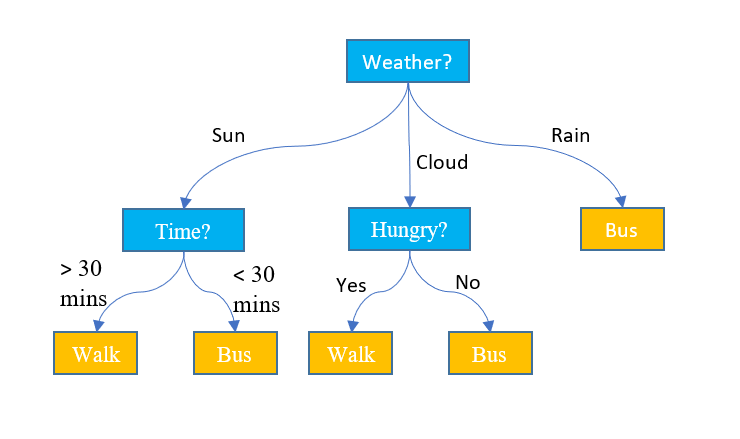

#### RANDOM FOREST: conjunto de decision tree promediados

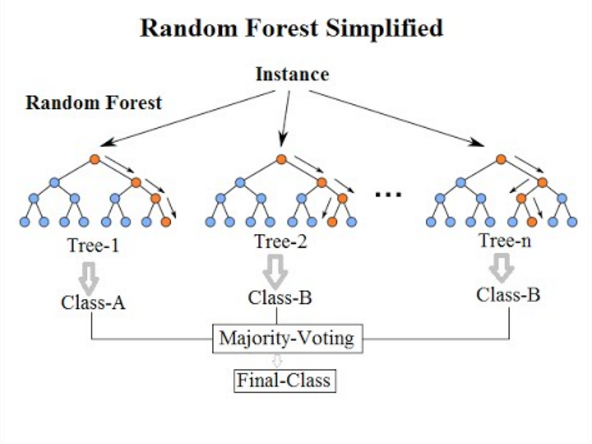

In [114]:
library(dplyr)
library(randomForest)
library(tidyverse)
library(forecast)


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ readr   1.3.1
✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ ggplot2 3.2.0     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ stringr::boundary()      masks strucchange::boundary()
✖ randomForest::combine()  masks dplyr::combine()
✖ lu

In [115]:
head(base_train)
head(base_test)

Year Weeknum Yearweek Sales_Liters Temp_Avg Class
1 2017 1       1        263778.2     22.88571 Train
2 2017 2       2        249777.5     23.24286 Train
3 2017 3       3        266308.4     23.52857 Train
4 2017 4       4        261133.6     21.95714 Train
5 2017 5       5        292004.5     24.58571 Train
6 2017 6       6        236130.0     21.11429 Train

Year Weeknum Yearweek Sales_Liters Temp_Avg Class
157 2020 157     1        297444.3     21.44286 Test 
158 2020 158     2        297221.2     21.98571 Test 
159 2020 159     3        285992.0     23.73333 Test 
160 2020 160     4        322162.2     21.37500 Test 
161 2020 161     5        287530.2     23.61429 Test 
162 2020 162     6        372673.3     21.38571 Test

In [116]:
rf = randomForest(Sales_Liters ~ Year + Weeknum + Yearweek + Temp_Avg , data = base_train)

In [117]:
print(rf)


Call:
 randomForest(formula = Sales_Liters ~ Year + Weeknum + Yearweek +      Temp_Avg, data = base_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 399772516
                    % Var explained: 76.56


In [118]:
predictions_train = predict(rf, newdata = base_train)
round(mape(base_train$Sales_Liters, predictions_train),2)

predictions_test = predict(rf, newdata = base_test)
round(mape(base_test$Sales_Liters, predictions_test),2)

[1] 3.84

[1] 16.2

MAPE es 4% en train y 16% en test, es un claro caso de overfitting.
Vamos a probar utilizando menos variables

In [119]:
varImpPlot(rf)

# Para ver que variables impactan más en el modelo

Yearweek y Temp_Avg son las variables que más influyen

In [120]:
rf_revised = randomForest(Sales_Liters ~ Yearweek + Temp_Avg , data = base_train)
print(rf_revised)


Call:
 randomForest(formula = Sales_Liters ~ Yearweek + Temp_Avg, data = base_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 558210144
                    % Var explained: 67.26


In [121]:
predictions_train = predict(rf_revised, newdata = base_train)
round(mape(base_train$Sales_Liters, predictions_train),2)

predictions_test = predict(rf_revised, newdata = base_test)
round(mape(base_test$Sales_Liters, predictions_test),2)

[1] 3.87

[1] 9.91

El modelo mejora desde 16% en test a 10%

Probamos utilizar solo la temperatura

In [122]:
rf_revised2 = randomForest(Sales_Liters ~ Temp_Avg , data = base_train)
print(rf_revised2)


Call:
 randomForest(formula = Sales_Liters ~ Temp_Avg, data = base_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 944755305
                    % Var explained: 44.6


In [123]:
predictions_train2 = predict(rf_revised2, newdata = base_train)
round(mape(base_train$Sales_Liters, predictions_train2),2)

predictions_test2 = predict(rf_revised2, newdata = base_test)
round(mape(base_test$Sales_Liters, predictions_test2),2)

[1] 5.56

[1] 13.93

Sube el error en train y test, es razonable porque nos quedamos sin variable de tiempo

In [124]:
head(predictions_test)

157      158      159      160      161      162 
283048.7 285721.4 271756.5 263674.6 288575.1 266826.7

In [125]:
RF_Pred <- data.frame(matrix(unlist(predictions_test), nrow=25, byrow=T))

colnames(RF_Pred)

[1] "matrix.unlist.predictions_test...nrow...25..byrow...T."

In [126]:

names(RF_Pred)[names(RF_Pred) == "matrix.unlist.predictions_test...nrow...25..byrow...T."] <- "Sales_Liters"
head(RF_Pred)

Sales_Liters
1 283048.7    
2 285721.4    
3 271756.5    
4 263674.6    
5 288575.1    
6 266826.7

In [127]:
RF_Pred$Weeknum <- c(157:181)
RF_Pred <- RF_Pred[, c(2,1)]
head(RF_Pred)

Weeknum Sales_Liters
1 157     283048.7    
2 158     285721.4    
3 159     271756.5    
4 160     263674.6    
5 161     288575.1    
6 162     266826.7

In [128]:
train1 <- base_train %>% select(c(Weeknum, Sales_Liters))
head(train1)

Weeknum Sales_Liters
1 1       263778.2    
2 2       249777.5    
3 3       266308.4    
4 4       261133.6    
5 5       292004.5    
6 6       236130.0

In [129]:
test <- base_test %>% select(c(Weeknum, Sales_Liters))
head(test)

Weeknum Sales_Liters
157 157     297444.3    
158 158     297221.2    
159 159     285992.0    
160 160     322162.2    
161 161     287530.2    
162 162     372673.3

In [130]:
plot(train1, xlim = c(0,181), main = "Train (negro), Test (rojo) y la predicción (azul)")
lines(RF_Pred, col='blue')
lines(test, col='red')

#### Vemos si los residuos del modelo son ruido blanco Gaussiano

In [134]:
residuals <- round(RF_Pred$Sales_Liters - test$Sales_Liters)

In [135]:
residuals_ts <- ts(residuals, start=157, end=181, frequency=1)
residuals_ts
ts.plot(residuals)

A Time Series:
 [1]  -14396  -11500  -14236  -58488    1045 -105847  -15884   -5897   27106
[10]  -55359 -158054  -72069  -13305    -607   -3319   41252   12716   15997
[19]    9094   24431    2838    9494    5383   22283   17617

In [136]:
checkresiduals(residuals_ts)

Warning message in modeldf.default(object):
“Could not find appropriate degrees of freedom for this model.”

El ACF da muy bien en una serie que ha demostrado tener muy alta autocorrelación. 

El ruido es blanco pero no llega a ser gaussiano. Entendemos que esto se da porque los grandes desaciertos son las compras de pánico en las que el modelo se queda corto, y no tiene
grandes errores donde se pase. Como no tuvimos compras de pánico en los datos de entrenamiento es entendible que esto suceda y no lo vemos como una falla del modelo.

Para mejorar las predicciones de cara a futuro podemos crear una nueva variable dummy que sea situación de emergencia y llenar las semanas de marzo y abril donde esto sucedió así el modelo
puede aprender de ello de cara a futuro y no nos altera a las demás variables.

# CONCLUSIONES

Utilizamos datos reales de venta de agua y de la temperatura, para los cuáles no había un estudio previo adaptado a la realidad de nuestro país.
Se trabajó mucho en la calidad de los datos previo a los análisis de la serie para poder llegar a un modelo que performe bien en la realidad y no sea sesgado por errores en los datos.

Realizamos 9 modelos en total (más varios que fueron a modo borrador) en los que incluimos diversas técnicas aprendidas en clase así como algunas otras que investigamos, ya sea con el libro
o con papers que encontramos en la web.

Estas técnicas incluyeron:

- Análisis de componentes estacionarias
- Ajustes lineales y no lineales
- Análisis de residuos
- Correlaciones cruzadas 
- Manejo de herramientas para series multivariables
- Técnicas de machine learning

Para validar los modelos utilizamos la metodología vista en clase de analizar el ruido y entender si es ruido blanco gaussiano con la menor varianza posible.
Además dividimos nuestro dataset en train y test y comparamos nuestras predicciones con los datos de test que el modelo no utilizó para entrenar, como herramienta para evitar overfitting y 
tener otro indicador de la efectividad de predicción del modelo a efectos de la elección del modelo.

Nuestros modelos que realizaron mejores predicciones fueron el Random forest así como el Modelo 7 (basado en el análisis de residuos y agregando las componentes estacionarias). Para hacer la elección entendemos que en accuracy están muy parejos, por lo que elegiríamos el Modelo 7 por su mayor interpretabilidad ya que tiene una base estadística con una clara explicación y no es tan randómica como es un random forest.
Igualmente nos quedamos con el random forest como modelo challenger para tener un respaldo y por si en los eventos futuros se adapta mejor a la dinámica de la realidad.
